In [7]:
import os 
# os.chdir("../src")
print(os.getcwd())

import gym
import numpy as np
from scipy.stats import multivariate_normal
from functools import partial

from utils.helpers import get_demo, extract_observable_state
from envs.goal_demo_wrapper import GoalDemoWrapper
from envs.time_feature_wrapper import TimeFeatureWrapper

/u/clw4542/research/rl_ifo_mujoco/src


### Naive Implementation

In [52]:
# checking average rewards from PBRS
demo_algo = "random"
env_id = "Ant-v2"
expert_demo = get_demo(env_id, demo_algo=demo_algo,
                       raw=True, shuffle=False, time_feat=True)

multivariates = [partial(multivariate_normal.pdf, 
                 mean=expert_demo[i], 
                 cov=np.eye(expert_demo.shape[1])) for i in range(1001)]

def compute_phi(state, ts):
    rpt_state = np.repeat(np.expand_dims(state, axis=0), repeats=1001, axis=0)
    res = []
    for i in range(expert_demo.shape[0]):
        res.append(multivariates[ts](rpt_state[i]))
    res = np.array(res)
    return np.max(res)


In [53]:
def run_episodes(env, env_id, n_eps, compute_phi=None):
    ep_lens, ep_rets = [], []
    for n in range(n_eps):
        done = False
        ep_len = 0
        ep_ret = 0
        ts = 0
        env.reset()
        while not done:
            obs, rew, done, info = env.step(env.action_space.sample())
            if compute_phi is not None:
                raw_obs = extract_observable_state(obs, env_id, True)
                rew = compute_phi(raw_obs, ts)
            ep_len +=1 
            ep_ret += rew
            ts +=1
        ep_lens.append(ep_len)
        ep_rets.append(ep_ret)
    return np.mean(ep_lens), np.mean(ep_rets)

env = gym.make(env_id)

In [55]:
%timeit run_episodes(env, env_id, n_eps=1, compute_phi=compute_phi)

2min 20s ± 5.37 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [50]:
%timeit run_episodes(env, env_id, n_eps=1, compute_phi=None)

589 ms ± 5.48 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### KD-Tree Implementation

In [65]:
from sklearn.neighbors import KDTree

rng = np.random.RandomState(0)
X = rng.random_sample((10, 3))  # 10 points in 3 dimensions

tree = KDTree(X, leaf_size=2, metric='euclidean'
#               metric_params={"V": np.eye(3)}
             )     
print(tree.query_radius(X[:1], r=0.3, count_only=True, workers=2))

ind = tree.query_radius(X[:1], r=0.3)  
print(ind)  # indices of neighbors within distance 0.3

TypeError: query_radius() got an unexpected keyword argument 'workers'

In [71]:
from scipy.spatial import cKDTree as KDTree

rng = np.random.RandomState(0)
X = rng.random_sample((10, 3))  # 10 points in 3 dimensions

tree = KDTree(X, leafsize=2)

tree.query(X[:1], k=2, p=2, n_jobs=2)

(array([[0.        , 0.19662693]]), array([[0, 3]]))

In [134]:
demo_algo = "random"
env_id = "Ant-v2"
expert_demo = get_demo(env_id, demo_algo=demo_algo,
                       raw=True, shuffle=False, time_feat=True)
exp_kdtree = KDTree(expert_demo) # 1001 points in n dims
dist_scale = 0.5

def compute_phi_kdtree(query_state, n_jobs):
    # k for k-nearest neighbors, p for p-norm
    dist, idx = exp_kdtree.query(query_state, k=1, p=2, n_jobs=n_jobs) # find expert state closest to query state
    similarity = np.exp(- 0.5 * (dist**2) * dist_scale)
    return similarity

def run_episodes(env, env_id, n_eps, n_jobs=None, compute_phi=None):
    ep_lens, ep_rets, ep_obs, ep_raw_obs = [], [], [], []
    for n in range(n_eps):
        done = False
        ep_len = 0
        ep_ret = 0
        ts = 0
        env.reset()
        while not done:
            obs, rew, done, info = env.step(env.action_space.sample())
            if compute_phi is not None:
                raw_obs = extract_observable_state(obs, env_id, True)
                rew = compute_phi(raw_obs, n_jobs)
                ep_raw_obs.append(raw_obs)
            ep_obs.append(obs)
            ep_len +=1 
            ep_ret += rew
            ts +=1
        ep_lens.append(ep_len)
        ep_rets.append(ep_ret)
    return np.mean(ep_lens), np.mean(ep_rets), np.mean(ep_obs), np.std(ep_obs), np.max(ep_obs), np.min(ep_obs)

env = gym.make(env_id)

In [96]:
%timeit run_episodes(env, env_id, n_eps=1, n_jobs=3, compute_phi=compute_phi_kdtree)

1.25 s ± 51.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [97]:
%timeit run_episodes(env, env_id, n_eps=1, n_jobs=1, compute_phi=compute_phi_kdtree)

695 ms ± 2.09 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [103]:
%timeit run_episodes(env, env_id, n_eps=1, n_jobs=1, compute_phi=compute_phi_kdtree)

725 ms ± 1.77 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Normalizing State Variables for Computing Phi

The SBS paper states that state variables are mapped to be between 0 and 1. The state space in Mujoco are joint angles, velocities, transformations of, etc. Elements of the state space are sometimes clipped to be within -10 and 10, but not always. We observe that $s$ tends to lie within [-20, 20].  Since there is no natural min/max on Mujoco state elements we cannot normalize. Since data standardization (i.e. subtract the mean and divide by the standard deviation) makes data $N(0,I)$ but does not bound data between [0,1] either, we don't do that either. Instead, we apply the logistic function with a temperature parameter that we tune.

Since the paper uses the full state to compute potentials, we also do that here. 

In [136]:
for env_id in ["Swimmer-v2", "Ant-v2", "HalfCheetah-v2", "Hopper-v2", "Walker2d-v2"]:
    env = gym.make(env_id)
    _, _, mean_obs, std_obs, max_obs, min_obs = run_episodes(env, env_id, n_eps=20, n_jobs=1)
    print(env_id, mean_obs, std_obs, max_obs, min_obs)

Swimmer-v2 0.00500333993697637 1.152980226856734 6.053521759531619 -6.426328595751195
Ant-v2 0.011484850795654507 1.2242938056075938 16.608095452167312 -18.486680430336296
HalfCheetah-v2 0.030077905070712275 3.889112417508262 24.380127172481114 -24.818120878265923
Hopper-v2 -0.5885770138047779 2.058176541435016 10.0 -10.0
Walker2d-v2 -1.0402280652602696 4.430968829700694 10.0 -10.0


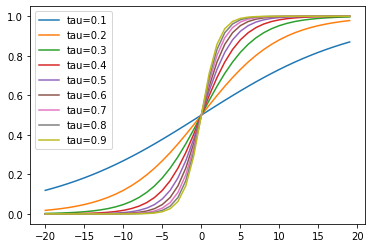

In [135]:
import matplotlib.pyplot as plt

def logistic(x, tau):
    return 1 / (1 + np.exp(tau * -x))

xs = np.arange(-20, 20)
for tau in np.arange(1, 10) / 10:
    ys = logistic(xs, tau)
    plt.plot(xs, ys, label=f"tau={tau}")
    plt.legend()